## A Tour of Dimensionality Reduction
___________________________

In [1]:
import pickle, gzip
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline

In [3]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train, test, val = pickle.load(f, encoding='latin')
    mnist_digit, mnist_label = train

### Manifold Learning Introduction

In the last notebook we explained how PCA acheives dimension reduction by finding principal components that maximize the varience of the projected data. However, PCA is limited to only linear transformations of the data. What about when the data is nonlinear? One famous example is the swiss-roll data set. Here the yellow points and the dark blue points are close apart in Euclidean distance but actually are far apart in geodesic distance (going "around" the manifold). The swiss roll is an example of a **manifold** - an inherently two dimensional object embedded in a higher dimensional space. A perfect algorithm should be able to discover this property and "unroll" the data. There are a number of **manifold learning** algorithms that try to do just this.

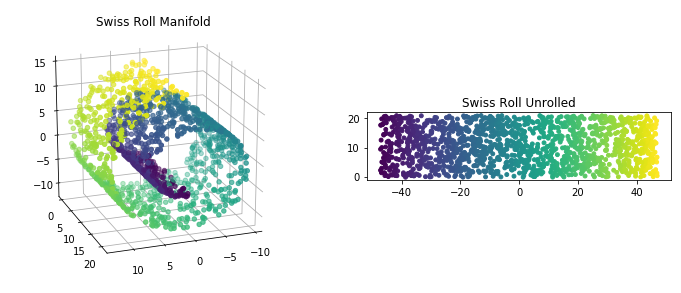

In [4]:
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D

X, color = datasets.samples_generator.make_swiss_roll(n_samples=1500, random_state=0)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=color, cmap='viridis')
ax.set_aspect('equal')
ax.view_init(20, 70)
ax.w_xaxis.set_pane_color((1, 1, 1, 1))
ax.w_yaxis.set_pane_color((1, 1, 1, 1))
ax.w_zaxis.set_pane_color((1, 1, 1, 1))
ax.set_title('Swiss Roll Manifold')

ax = fig.add_subplot(122)
plt.scatter(10 * color - np.mean(10 * color), X[:, 1], c=color, s=15)
ax = plt.gca()
ax.set_aspect('equal')
ax.set_title('Swiss Roll Unrolled')
pass

### Kernel PCA

A limitation of PCA is that it only produces linear transformations of the data. An extension that addresses this issue is called **kernel PCA**. This method produces a non-linear transformation of the data by performing PCA in a [reproducing kernel Hilbert space](https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space). In essence, 

kernel functions allow us work in a higher dimensional space than the original data without having to compute the coordinates of the space directly. This is often called the [kernel trick](https://en.wikipedia.org/wiki/Kernel_method) and it means we can compute nonlinear transformations of the data by computing only inner products, a much more efficient operation. 

Kernel PCA performance depends on the choice of kernel function and parameters. Somes examples include 

* **Linear**: $<x, x'>$. The typical inner (dot) product. Equivalent to $N$-dimensional Euclidean distance.
  
  
* **Polynomial** - $(<x, x'> + r)^d$. The parameter $d$ is the degree of the polynomial and can be tuned.

  
* **Radial basis function**: $\text{exp}(-\gamma \ ||x - x'||^2)$. Equivalent to centering a symmetric $N$-dimensional Gaussian distribution over each data point. The choice of bandwidth $\gamma$ is a tuning parameter. 

Below is the swiss roll data set decomposed using kernel PCA with the radial basis function and different values for $\gamma$. For very small $\gamma$, the kernel PCA produces a result similar to linear PCA because the distances become close to constant. As $\gamma$ increases the shape of the projections markedly change, although none are very close to optimal unrolled reconstruction. This is because kPCA does not model the distances along the manifold directly, leading to very distorted reconstructions.

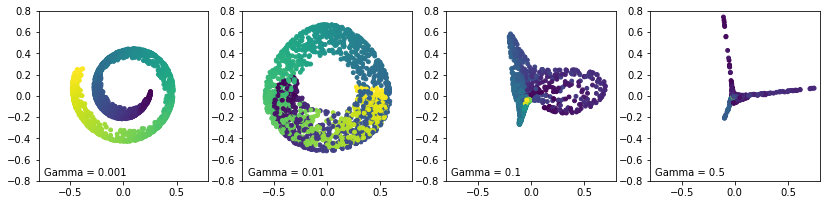

In [5]:
from sklearn.decomposition import PCA, KernelPCA
np.random.seed(0)

gamma = [0.001, 0.01, 0.1, 0.5]
fig, ax = plt.subplots(1, len(gamma), figsize=(14, 5))

for i, g in enumerate(gamma):
    kpca = KernelPCA(n_components = 2, kernel = 'rbf', gamma=g)
    X_kpca = kpca.fit_transform(X)
    
    ax[i].scatter(X_kpca[:,0], X_kpca[:,1], c=color, s=15)
    ax[i].set_xlim((-0.8, 0.8))
    ax[i].set_ylim((-0.8, 0.8))
    ax[i].set_aspect('equal')
    
    ax[i].text(-0.75, -0.75, 'Gamma = {}'.format(g))
pass

### Locally Linear Embedding

The issue with PCA and kPCA that makes it poorly suited to manifold learning problems is that the algorithm tries to perserve large variations in the data. Sometimes the direction with the most variation is not the most salient one, as in the case of the swiss roll data set. Manifold learning algorithms overcome this by attempting to perserve distances between closely neighboring points. 

Locally linear embedding (**LLE**) attempts to strike a balance between perserving local geometry and global scale. The algorthms starts by finding the $k$ nearest neighbors in feature space for each data point. Then it builds a weight matrix that represents a $d$-dimensional linear reconstruction of each point using its $k$ neighbors. Finally a global reconstruction is done using eigenvalue decomposition along with the weights. Intuitively, LLE performs PCA on local patches of the manifold and compares all the patches globally. This results in perserving local and global distances.

Although LLE unravels the swiss roll, the resulting image is distorted. LLE can fail if the data is not locally linear - if a point cannot be linearlly reconstructed using its $k$ nearest neighbors. In this case, the data has greater curviture towards the center than towards the outside causing the distortion.

In [61]:
from sklearn.manifold import LocallyLinearEmbedding

np.random.seed(0)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
swiss_lle = lle.fit_transform(X)

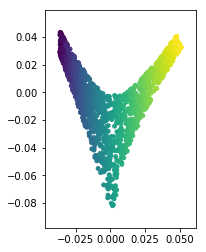

In [62]:
plt.scatter(swiss_lle[:,0], swiss_lle[:,1], c=color, s=15)
ax = plt.gca()
ax.set_aspect('equal')
pass

### Isomap

We saw that the normal variations of kernel PCA are not readily suited to manifold learning and LLE produces a distorted image. We could do this by directly modeling distances along the manifold. The shortest distance between two points in curved space is called the **geodesic** distance. Airplanes fly in [great circle](https://en.wikipedia.org/wiki/Great-circle_distance) paths following the curvature of the Earth for this reason.

LLE implicitly models manifold geometry by weighting local points. Another algorithm called Isometric mapping or **Isomap** explicitly models the manifold. It tries to perserve geodesic distrances from the original to the reconstruction. Isomap procedes in three steps. First, a edge-weighted graph is built connecting each point to its $k$-nearest neighbors in feature-space just as in LLE. Then, we run the [Ford-Warshall algorithm](https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm) or similar to find the shortest paths between all points. We treat these shortest distances as an approximation of the true geodesic distance along the manifold. Finally, a lower dimensional embedding is computed by using kernel PCA where the geodesic distance matrix is used as a kernel matrix. 

Because we are perserving geodesic distances, the swiss roll can be unrolled with minimal global distortion. Some local distortion does occur due to the estimation of geodesic distances with small $k = 5$. A larger value such as $k = 10$ produces better results. Manifold learning algorthms that use $k$-NN may have issues with edges with certain values of $k$. Illustrated below are outputs for $k=5$ and $k=30$. We mistakenly have the ends of the swiss roll connecting because due to some of the closest points being in a non-connected region.

In [42]:
from sklearn.manifold import Isomap

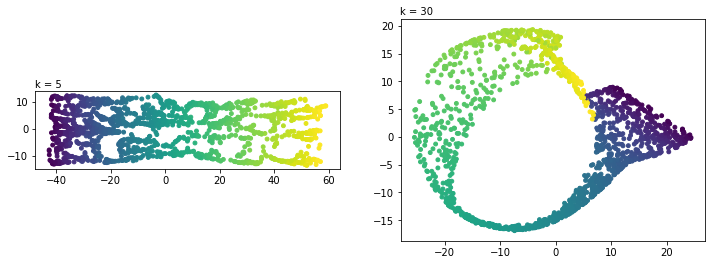

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

np.random.seed(1)
iso = Isomap(n_components=2, n_neighbors=5)
swiss_iso = iso.fit_transform(X)

ax[0].scatter(swiss_iso[:,0], swiss_iso[:,1], c=color, s=15)
ax[0].text(-48, 15, 'k = 5')
ax[0].set_aspect('equal')

iso = Isomap(n_components=2, n_neighbors=30)
swiss_iso = iso.fit_transform(X)

ax[1].scatter(swiss_iso[:,0], swiss_iso[:,1], c=color, s=15)
ax[1].set_aspect('equal')
ax[1].text(-28, 22, 'k = 30')

pass

### MNIST 

In [89]:
n = 3000
iso = Isomap(n_components=2)
mnist_iso = iso.fit_transform(mnist_digit[0:n])

In [95]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
mnist_lle = lle.fit_transform(mnist_digit[0:n])

In [91]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
mnist_pca = pca.fit_transform(mnist_digit[0:n])

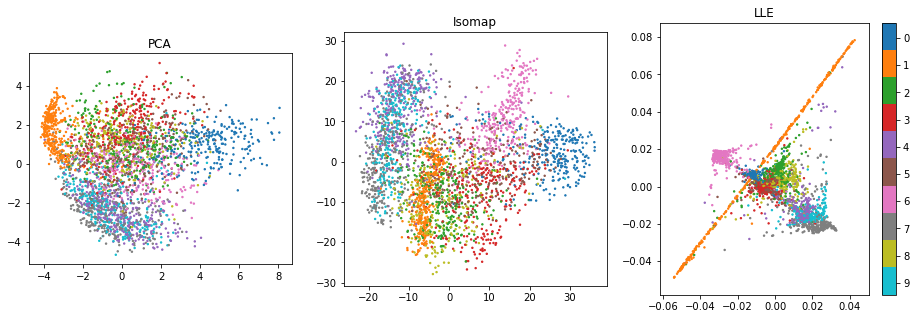

In [98]:
fig = plt.figure(figsize=(16, 5))

fig.add_subplot(131)
plt.scatter(mnist_pca[:,0], mnist_pca[:,1], c=mnist_label[0:n], s=2, cmap='tab10')
ax = plt.gca()
ax.set_aspect('equal')
ax.set_title('PCA')

fig.add_subplot(132)
plt.scatter(mnist_iso[:,0], mnist_iso[:,1], c=mnist_label[0:n], s=2, cmap='tab10')
ax = plt.gca()
ax.set_aspect('equal')
ax.set_title('Isomap')

fig.add_subplot(133)
plt.scatter(mnist_lle[:,0], mnist_lle[:,1], c=mnist_label[0:n], s=2, cmap='tab10')
ax = plt.gca()
ax.set_aspect('equal')
ax.set_title('LLE')

cbar = plt.colorbar()
cbar.ax.invert_yaxis() 
cbar.set_ticks(np.arange(10) * 0.9 + 0.5)
cbar.set_ticklabels(np.arange(10))
pass

### Resources
_________________________

An overview of manifold learning is given in [this](https://www.linkedin.com/pulse/visualising-mnist-dataset-manifold-learning-vijayasaradhi-indurthi/) post. The connection between kernel PCA and manifold learning algorithms is explained nicely [here](http://www.vision.jhu.edu/reading_group/Readinggroup_kpca.pdf). [Here](http://www.cs.cmu.edu/~efros/courses/AP06/presentations/melchior_isomap_demo.pdf) is a comparison of various manfold learning algorithms on a number of data sets.

In [74]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')